In [1]:
import pandas as pd

#cargar el archivo
df = pd.read_excel('Retail_Invoices.xlsx')

#mostrar las primeras filas
df.head()


,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1


In [2]:
#hacemos limpieza de datos
df.isnull().sum()
df.info()
#cantidades o precios negativos o iguales a cero
anomalías = df[(df['Quantity'] <= 0) | (df['price_total'] <= 0)]
anomalías.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22190 entries, 0 to 22189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22190 non-null  object        
 1   InvoiceDate  22190 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  int64         
 3   Quantity     22190 non-null  int64         
 4   price_total  22190 non-null  float64       
 5   StockCode    22190 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.0+ MB


,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
2721,543599,2011-02-10,17560,16,0.0,1
11301,564651,2011-08-26,14646,576,0.0,4
12848,568384,2011-09-27,12748,1,0.0,1
17360,578841,2011-11-25,13256,12540,0.0,1
18536,C536379,2010-12-01,14527,-1,-27.5,1


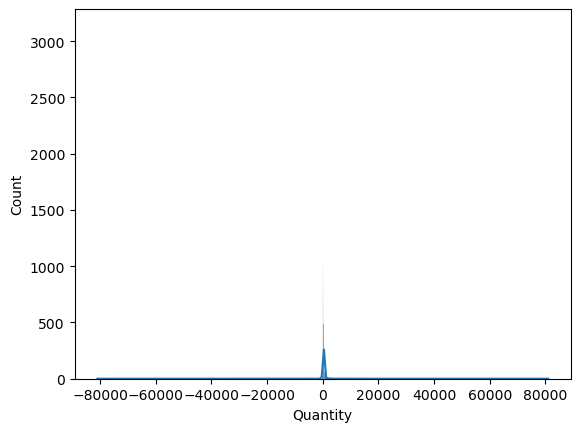

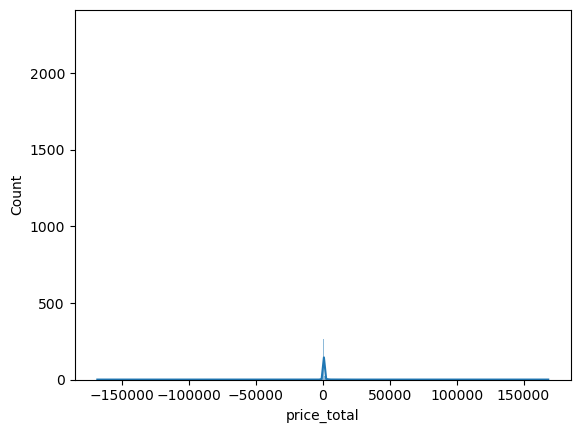

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

#distribucion de cantidad de compras
sns.histplot(df['Quantity'], kde=True)
plt.show()

#distribucion de precios totales
sns.histplot(df['price_total'], kde=True)
plt.show()


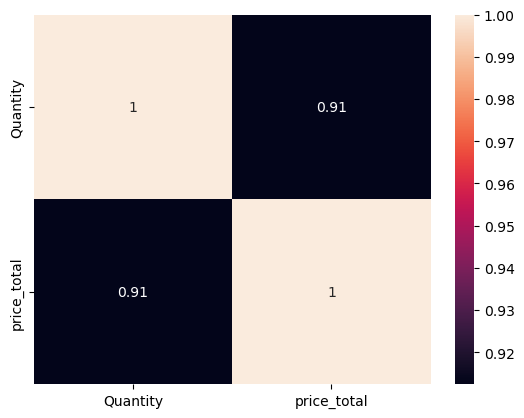

In [4]:
corr = df[['Quantity', 'price_total']].corr()
sns.heatmap(corr, annot=True)
plt.show()


Paso 2 Generar variables a nivel de cliente (RFM)

In [6]:
from datetime import datetime

# Convertir InvoiceDate a datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Encontrar la fecha más reciente
fecha_actual = df['InvoiceDate'].max()

# Calcular Recencia por cliente
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (fecha_actual - x.max()).days
}).rename(columns={'InvoiceDate': 'Recencia'})


In [7]:
frecuencia = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique'
}).rename(columns={'InvoiceNo': 'Frecuencia'})


In [8]:
monto = df.groupby('CustomerID').agg({
    'price_total': 'sum'
}).rename(columns={'price_total': 'Monto'})


In [9]:
monto = df.groupby('CustomerID').agg({
    'price_total': 'sum'
}).rename(columns={'price_total': 'Monto'})


In [10]:
rfm = rfm.merge(frecuencia, on='CustomerID').merge(monto, on='CustomerID')
rfm.head()


,Recencia,Frecuencia,Monto
CustomerID,,,
12346,325,2,0.00
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40


Paso 3: Análisis exploratorio de las variables RFM

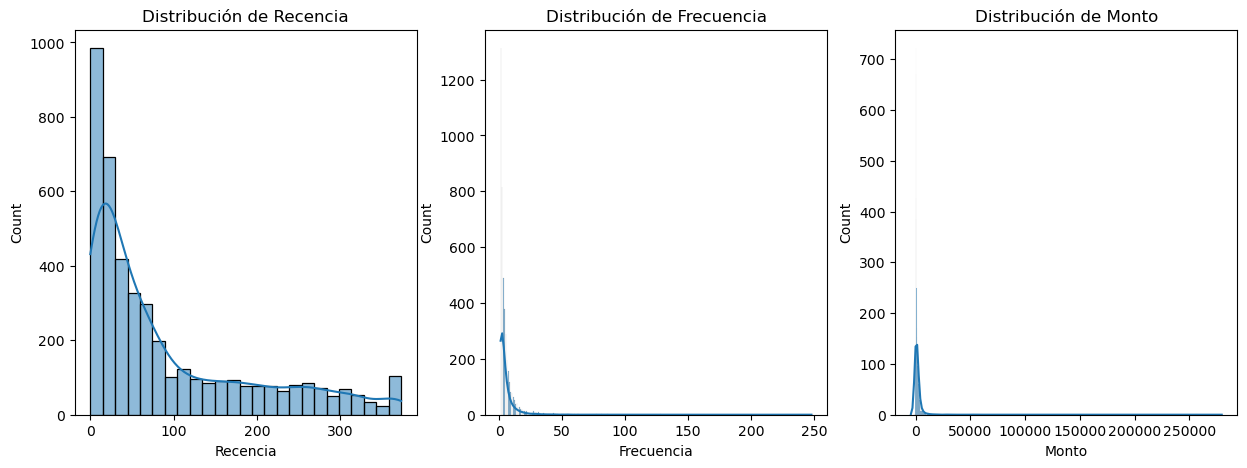

In [11]:
# raficar las distribuciones de R, F, M
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(rfm['recencia'], kde=True, ax=axs[0])
sns.histplot(rfm['frecuencia'], kde=True, ax=axs[1])
sns.histplot(rfm['monto'], kde=True, ax=axs[2])

axs[0].set_title('distribucion de Recencia')
axs[1].set_title('distribucion de Frecuencia')
axs[2].set_title('distribucion de Monto')
plt.show()


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


Paso 4: Aplicar algoritmos de clustering

C:\Users\FpymeTarapaca\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\FpymeTarapaca\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\FpymeTarapaca\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\FpymeTarapaca\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

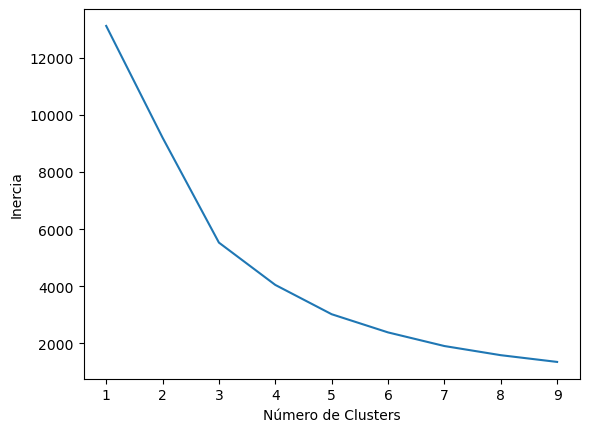

In [14]:
#K-means:
from sklearn.cluster import KMeans
import numpy as np

#Aplicar K-means
kmeans = KMeans(n_clusters=4, random_state=0)
rfm['Cluster_KMeans'] = kmeans.fit_predict(rfm_scaled)

#Visualizar la inercia para determinar el mejor numero de clusters
inercia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(rfm_scaled)
    inercia.append(kmeans.inertia_)

plt.plot(range(1, 10), inercia)
plt.xlabel('Numero de Clusters')
plt.ylabel('Inercia')
plt.show()


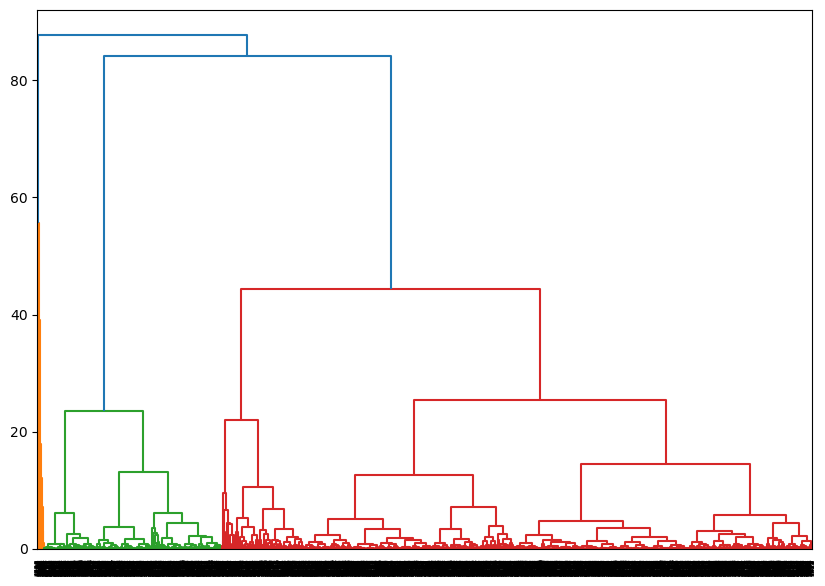

In [16]:
#Clustering jerarquico:
from scipy.cluster.hierarchy import dendrogram, linkage

#Calcular linkage jerarquico
Z = linkage(rfm_scaled, method='ward')

#Dibujar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.show()


Paso 5: Evaluar la calidad y caracterizar los clusters

In [17]:
#Evaluar la calidad del clustering
from sklearn.metrics import silhouette_score

score = silhouette_score(rfm_scaled, rfm['Cluster_KMeans'])
print(f"Silhouette Score para K-means: {score}")


Silhouette Score para K-means: 0.6113314002454021


In [18]:
#Caracterizar los clusters:
rfm.groupby('Cluster_KMeans').agg({
    'Recencia': 'mean',
    'Frecuencia': 'mean',
    'Monto': 'mean'
}).rename(columns={'Recencia': 'Promedio Recencia', 'Frecuencia': 'Promedio Frecuencia', 'Monto': 'Promedio Monto'})


,Promedio Recencia,Promedio Frecuencia,Promedio Monto
Cluster_KMeans,,,
0,247.483901,1.804968,452.722476
1,8.609091,40.672727,18441.961455
2,41.144841,4.802777,1478.778426
3,7.166667,89.000000,182181.981667
